<a href="https://colab.research.google.com/github/NithinUppara2003/Projects/blob/main/farm_insect_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set up**

---


In [ ]:
pip install --upgrade kaggle


In [ ]:
!ls -lha kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

-rw-r--r-- 1 root root 68 Dec  9 16:40 kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tarundalal/dangerous-insects-dataset

dangerous-insects-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
import os

zip_file_path = '/content/dangerous-insects-dataset.zip'
extract_dir = '/content/dangerous-insects-dataset'

with ZipFile(zip_file_path, 'r') as zipObj:
    # Check if the extract directory exists, if not, create it
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    zipObj.extractall(extract_dir)


This section **lays the foundation** for a **seamless and efficient notebook experience** by **importing essential modules**. It ensures a **smooth workflow** by providing all the **necessary tools and functionalities** required for **subsequent operations**. In addition to the **imports**, this **section establishes vital constants** that will **play a pivotal role** in **various stages** of **the notebook**, **enhancing its overall performance and reliability**. By setting up the **fundamental components** and **establishing a robust framework**, this section **paves the way** for an **exciting journey** of **exploration and analysis**, where the **full potential** of the **notebook** can be **harnessed** to **accomplish extraordinary tasks.**


In [ ]:
pip install keras-tuner


In [ ]:
pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
# Management Modules
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter

# Data loading and transformation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-trained models
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception

# Model Layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hyertunig and Metrices
from kerastuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Set up random seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Specify the root file path
directory_path = "/kaggle/input/dangerous-insects-dataset/farm_insects/"
N_CLASSES = 15
IMAGE_SIZE = (224,224,3)


def create_callbacks(name, patience):
    """
    Create a list of callbacks for model training.

    Parameters:
        name (str): Name of the model for saving purposes.
        patience (int): Number of epochs to wait for improvement in validation loss.

    Returns:
        list: List of callbacks including EarlyStopping and ModelCheckpoint.
    """
    return [
        EarlyStopping(patience=patience, restore_best_weights=True, verbose=1),
        ModelCheckpoint(name + ".h5", save_best_only=True, monitor="val_loss")
    ]

# **Data Loading, Processing & Visualization**

---

In this section, **our primary focus** is on **efficiently loading** the **images corresponding to each class** into memory for easy access. Additionally, we will **preprocess the data** to **ensure compatibility with our models**. By loading the images into memory, we can **readily access and manipulate the data** during **model training** and **evaluation**. The preprocessing step involves transforming the **image data into a suitable format** that can be **effectively utilized by the models**. This may include **resizing, normalizing, and other necessary transformations** to ensure **optimal performance**. Through these steps, we aim to create a **well-prepared dataset** that is ready to be fed into our models for **effective learning and inference**.


In [ ]:
import os

directory_path = '/content/dangerous-insects-dataset'

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"Error: The directory '{directory_path}' does not exist.")
else:
    # Collect the class names
    class_names = os.listdir(directory_path)

    # Show the information
    print(f"Number of Classes: {len(class_names)}")
    print("Class Names:")
    for index, name in enumerate(class_names):
        print(f"{index + 1:2}. {name}")


Number of Classes: 1
Class Names:
 1. farm_insects


In [ ]:
# Collect the class names
class_names = os.listdir(directory_path)

# Show the information
print(f"Number of Classes: {N_CLASSES}")
print("Class Names:")
for index, name in enumerate(class_names):
    print(f"{index + 1:2}. {name}")

Number of Classes: 15
Class Names:
 1. farm_insects


To **ensure efficient training and robust inference**, it is crucial to have a **non-biased dataset** where each **insect class** has an **equal number of images**. In other words, **all classes** should have the **same sample size**. Having a **balanced dataset prevents certain classes** from **becoming rare**, which can **negatively impact model performance**.

When **some classes** have a **significantly smaller number of samples compared to others**, it can lead to **imbalanced learning**. In such cases, the **model may struggle** to **learn important features** from the **underrepresented classes**, resulting in **poor performance** and **biased predictions**. Instead of **learning meaningful patterns**, the **model may resort to guessing or favoring the majority classes**, compromising its **overall effectiveness**.

By ensuring an **equal sample size** for **each class**, we create a **level playing field** for the **model to learn from the available data**. This allows for a **fair and unbiased representation** of **all insect classes during training**, enabling the model to **make accurate predictions** across the **entire range of classes**.


In [ ]:
import os
import pandas as pd

class_names = ["farm_insects"]  # Replace with the actual class names
directory_path = "/content/dangerous-insects-dataset"  # Replace with the actual directory path

class_sample_size = [len(os.listdir(os.path.join(directory_path, class_name))) for class_name in class_names]

# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images * 100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

# Calculate the rank of each class based on data size
class_distribution_df["Rank"] = class_distribution_df["Data Size"].rank(method="dense", ascending=False)

# Show the data
print(class_distribution_df)


    Class Names  Data Size  Percentage(%)  Rank
0  farm_insects         15          100.0   1.0


In [ ]:
# Visualize the class distribution
fig = px.bar(
    data_frame=class_distribution_df,
    x="Class Names",
    y="Data Size",
    text="Data Size",
    hover_data=["Percentage(%)", "Rank"],
    title="Class Distribution of Insects in the Dataset",
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
)

# Set axis labels and adjust layout
fig.update_layout(
    xaxis_title="Class Names",
    yaxis_title="Data Size",
    yaxis_tickformat="d",
    yaxis=dict(showgrid=False),
    showlegend=False,
)

# Show the plot
fig.show()

**Class Distribution**

The **class distribution** of the dataset provides **valuable insights** into the **number of images per class**, **shedding light on the balance or imbalance within the dataset**. In this **particular dataset**, the **number of images varies across the different insect classes**, indicating an **imbalanced distribution**. Some classes **exhibit higher sample sizes**, exemplified by **"Spider Mites"** with **119 images**, while others demonstrate **smaller sample sizes**, as seen in **"Aphids"** with **88 images**. This inherent imbalance **poses a challenge** for **training and model performance**, as the model **may struggle** to learn and **generalize effectively across all classes**.

**Rare Classes**

Within the dataset, **certain classes are considered rare** due to their **relatively smaller sample sizes** compared to other classes. Notable examples of **rare classes** in this **dataset include** **"Africanized Honey Bees (Killer Bees)," "Aphids," and "Armyworms."** The scarcity of instances representing these classes **presents a challenge during model training** and **may result in lower performance** in accurately identifying and classifying these rare insects. The **limited representation** of **rare classes** can hinder the model's ability to **capture their unique features** and **patterns**, potentially leading to **reduced accuracy** and **precision** in predicting their presence.

**Common Classes**

Conversely, several classes in the dataset **exhibit larger sample sizes**, making them **more prevalent** and **abundant**. Noteworthy examples of **such common classes** include **"Spider Mites," "Corn Borers," and "Fall Armyworms."** These classes benefit from **having a higher number of training examples available**, providing the **model with more opportunities** to **learn and understand** their **distinctive characteristics**. The abundance of instances in **common classes** allows the **model to capture** and **leverage their defining features**, potentially leading to **improved accuracy** and **performance in classifying these insects**.

---

## **Class Weights**

One method to address the **class imbalance** problem during training is by using **_class weights_**. **_Class weights_** assign **different weights to each class** based on their **frequency in the dataset**. By adjusting the weights, the **model gives more importance to the minority class during training**, helping to **mitigate the impact of class imbalance**.


In [ ]:
# Computer class weights.
class_weights = [total_n_images / (N_CLASSES * class_samples)
                 for class_samples in class_sample_size]

# Add this data into the data frame
class_distribution_df["Class Weights"] = class_weights

# Show the updated data
class_distribution_df

Class Names  Data Size  Percentage(%)  Rank  Class Weights
0  farm_insects         15          100.0   1.0       0.066667

While the **class distribution analysis** aids in addressing the issue of **class imbalance** during **training**, it is imperative to employ a **suitable data splitting strategy** that **incorporates stratification**. Failure to do so could render the **class distribution analysis ineffective**. **Stratified data splitting** ensures that the **train and test sets** retain a **representative distribution of classes**, **mirroring that of the original dataset**. By preserving the **relative proportions** of **each class,** this approach **prevents the introduction of bias** and **facilitates an accurate evaluation** of the **model's performance**.


In [ ]:
from sklearn.model_selection import train_test_split
import glob

# Initialize empty lists to collect image paths and class labels
all_image_paths = []
class_labels = []

# Collect all image paths and corresponding class labels
for class_name in class_names:
    paths = glob.glob(directory_path + f"/{class_name}/*")
    all_image_paths.extend(paths)
    class_labels.extend([class_name] * len(paths))

# Perform stratified data split
train_images, valid_test_images, train_labels, valid_test_labels = train_test_split(
    all_image_paths, class_labels, train_size=0.8, test_size=0.2, stratify=class_labels)

# Further split the valid_test set into validation and test sets
valid_images, test_images, valid_labels, test_labels = train_test_split(
    valid_test_images, valid_test_labels, train_size=0.9, test_size=0.1)


While we have utilized the reliable **train-test split** function from the **scikit-learn library** to perform a **stratfied data split**, it is always **prudent to crosscheck** the **final results** to ensure their **accuracy and reliability**. By conducting a **thorough verification** of the **train section images**, we can **fortify our confidence** in the **integrity of the data split process** and its **subsequent impact** on **the training phase**. This **diligent crosschecking** will provide us with **valuable insights** and **assurance regarding the composition and representation of the training data**, paving the way for a **more robust and fruitful model training experience.**


In [ ]:
# Extract class labels for trained images
trained_class_labels = [os.path.split(path)[0].split("/")[-1] for path in train_images]

# Compute class distribution
class_distribution = dict(Counter(trained_class_labels))

# Compute class weights
total_trained_images = len(train_images)
train_class_weights = {class_label: total_trained_images /
                       (N_CLASSES * class_samples) for class_label, class_samples in class_distribution.items()}

# Display the class weights of the training images
print(f"  Class Name {' '*27} Train Class Weight {' '} Original Class Weights")
for index, (name, weight) in enumerate(train_class_weights.items()):
    original_weight = class_distribution_df[class_distribution_df["Class Names"]
                                            == name]["Class Weights"].values[0]
    print(f"{index+1:2}. {name:40} {weight:.3f} {original_weight:25.3f}")

  Class Name                             Train Class Weight   Original Class Weights
 1. farm_insects                             0.067                     0.067


This is **precisely the outcome we aimed for**. The congruence between the **original class distribution** and the **class distribution** of the **trained images affirms** that our model will be **trained effectively**, successfully mitigating **any class imbalance** issues inherent in the data. By leveraging the **class weights** and implementing a **stratified split technique**, we have **effectively addressed the class imbalance challenge**, ensuring that our model receives **balanced and representative training** across **all classes**. This achievement instills confidence in the **reliability and robustness of our model**, setting the stage for **accurate and comprehensive predictions** in **real-world scenarios**.

---

Now that we have **successfully addressed the challenge of class imbalance**, the next step is to **load the data**. To streamline the **data loading process** and **ensure efficiency**, we will **encapsulate the necessary functions within a class**, consolidating **all the functionalities in a single place**. This approach enables us to **seamlessly load the data**, leveraging the **pre-defined train, test, and validation data splits**. By creating dedicated functions for loading these datasets, we can achieve a **streamlined and organized workflow**, facilitating efficient **data loading procedures.**


In [ ]:
class FarmInsects:
    """
    A class for loading and processing farm insect images dataset.
    """

    def __init__(self, class_names: list, n_classes: int, image_size: tuple = (256, 256, 3)):
        """
        Initialize FarmInsects class.

        Args:
            class_names (list): List of class names.
            n_classes (int): Number of classes.
            image_size (tuple): Size of the images (height, width, channels).
        """
        self.image_size = image_size
        self.class_names = class_names
        self.n_classes = n_classes

    def load_image(self, image_path: str) -> tf.Tensor:
        """
        Load and preprocess an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            tf.Tensor: Preprocessed image tensor.
        """
        image_file = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_file, channels=3)
        image = tf.image.resize(image, self.image_size[:2])
        image = image / 255.

        return image

    def extract_label(self, image_path: str, names: bool = False) -> int or str:
        """
        Extract the label from the image path.

        Args:
            image_path (str): Path to the image file.
            names (bool): Whether to return class names or numerical labels.

        Returns:
            int or str: Numerical label or class name.
        """
        name = os.path.split(image_path)[0].split("/")[-1]
        if names:
            return name
        else:
            label = self.class_names.index(name)
            return label

    def load_data(self, image_paths: list, desc: str = "Loading", one_hot: bool = True, names: bool = False) -> tuple:
        """
        Load the images and labels from the given image paths.

        Args:
            image_paths (list): List of image paths.
            desc (str): Description for tqdm progress bar.
            one_hot (bool): Whether to use one-hot encoding for labels.
            names (bool): Whether to return class names instead of numerical labels.

        Returns:
            tuple: Tuple containing the loaded images and labels.
        """
        self.images = np.empty((len(image_paths),) + self.image_size, dtype=np.float32)

        if names:
            self.labels = []
        else:
            self.labels = np.empty((len(image_paths),), dtype=np.int32)

        for index, path in tqdm(enumerate(image_paths), desc=desc):
            image = self.load_image(image_path=path)
            label = self.extract_label(image_path=path, names=names)
            self.images[index] = image

            if names:
                self.labels.append(label)
            else:
                self.labels[index] = label

        if one_hot and not names:
            one_hot_labels = tf.one_hot(self.labels, depth=self.n_classes)
            return self.images, one_hot_labels
        else:
            return self.images, self.labels

    def show_random_images(self, grid: tuple, image_paths: list, figsize: tuple = (25, 20)):
        """
        Display random images from the given image paths.

        Args:
            grid (tuple): Tuple specifying the grid size (number of rows, number of columns).
            image_paths (list): List of image paths.
            figsize (tuple): Figure size for displaying the images.
        """
        n_rows, n_cols = grid
        n_images = n_rows * n_cols

        image_indexes = np.random.randint(0, len(image_paths), size=n_images)
        image_paths = np.take(image_paths, image_indexes)

        images, labels = self.load_data(image_paths=image_paths, one_hot=False, names=True)

        plt.figure(figsize=figsize)

        for plot_index in range(1, n_images + 1):
            plt.subplot(n_rows, n_cols, plot_index)
            plt.imshow(images[plot_index - 1])
            plt.title(label=labels[plot_index - 1])
            plt.axis('off')

        plt.show()


It's time to load data,

In [ ]:
farm_data = FarmInsects(class_names=class_names, n_classes=N_CLASSES, image_size=IMAGE_SIZE)


In [ ]:
trainXs, trainYs = farm_data.load_data(image_paths=train_images, desc="Training Data")
testXs, testYs = farm_data.load_data(image_paths=test_images, desc="Testing Data")
validXs, validYs = farm_data.load_data(image_paths=valid_images, desc="Validation Data")



Training Data: 0it [00:00, ?it/s]


FailedPreconditionError: ignored

In [ ]:
import os

def load_data(self, image_paths, desc="Data"):
    X_data = []
    Y_data = []

    for path in image_paths:
        if os.path.isdir(path):
            # If the path is a directory, get all image files within the directory
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            X_data.extend(files)
            Y_data.extend([self.class_names.index(os.path.basename(path))] * len(files))
        else:
            # If the path is a file, append it directly
            X_data.append(path)
            Y_data.append(self.class_names.index(os.path.basename(os.path.dirname(path))))

    # Rest of the function remains the same
    # ...

# Then use this modified function for loading data
trainXs, trainYs = farm_data.load_data(image_paths=train_images, desc="Training Data")
testXs, testYs = farm_data.load_data(image_paths=test_images, desc="Testing Data")
validXs, validYs = farm_data.load_data(image_paths=valid_images, desc="Validation Data")


Training Data: 0it [00:00, ?it/s]


FailedPreconditionError: ignored

Now that we have **successfully loaded the data**, let's take a **closer look** at our **dataset**. We will **randomly select** and **plot some images** from the **dataset** to get a **visual understanding** of the **training samples**. This will provide us with a **rough estimate** of the **appearance and characteristics of our training data**.

In [ ]:
# Using in-built method
farm_data.show_random_images(image_paths=train_images, grid=(5,5))

Loading: 0it [00:00, ?it/s]


FailedPreconditionError: ignored

The **images** in our **dataset** are of **good quality and provide a clear representation of farms and insects**. This will enable our model to **learn the distinctive features** that characterize **farms and insects effectively**. However, it is worth noting that for **certain classes** like **citrus canker and cabbage loopers**, some images may **depict affected plant parts** rather than the **actual insects**. If the number of **such images** is limited, it should **not significantly impact the model's ability to detect farm insects**. However, if there is a **substantial count of such images**, it may **pose a challenge** for the **model**, as it **might focus more on detecting the symptoms of diseases** rather than identifying the **insects themselves, which is the primary objective**.

# **Backbone Selection**

Given the **limited number of available images**, we will adopt a **transfer learning approach**, which **offers significant advantages** in capturing **relevant features** present in the **farm insects**. This approach allows us to **leverage pre-trained models**, such as **ResNet, MobileNet, VGG, and others**, that have demonstrated **exceptional performance** on various tasks. Our goal is to identify the **most suitable network architecture for our specific classification task**.

To accomplish this, we will **conduct a systematic evaluation** of these models by **assessing their accuracy, F1 score, precision, recall, and loss metrics.** Through this evaluation, **we aim to select the model that achieves the best performance on our dataset**. In order to facilitate this process, we will create a **class object that encompasses functions for model training, model visualization, and model comparison.**

Similar to **our previous class object** for **handling the dataset**, this **new class object** will **streamline the model training process** and **enable us to effectively compare different models**. By **leveraging the strengths** of these **pre-trained networks**, we can **enhance the accuracy and efficiency** of our classification task, despite the **limited availability of data**.

In [ ]:
# Converting the class weights from a list to dictionary
class_weights_dict = dict(zip(range(N_CLASSES), class_distribution_df["Class Weights"]))

In [ ]:
class Model:
    models = [
        ResNet50V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        ResNet152V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
    ]

    model_names = [
        "ResNet50V2",
        "ResNet152V2",
        "MobileNetV2",
        "Xception"
    ]

    def __init__(self, model_name: str):
        """
        Initialize the Model class with the specified pre-trained model.

        Args:
            model_name (str): Name of the pre-trained model to be used.
        """
        self.model_name = model_name
        self.index = self.model_names.index(model_name)
        self.backbone = self.models[self.index]

    def train(self, trainXs, trainYs, validation_data, epochs=10, batch_size=32, verbose=1):
        """
        Train the model using the specified training and validation data.

        Args:
            trainXs (numpy.ndarray): Training images.
            trainYs (numpy.ndarray): Training labels.
            validation_data: Validation data as a tuple (valXs, valYs).
            epochs (int): Number of epochs to train the model.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training logs (0, 1, or 2).
        """
        self.backbone.trainable = False

        self.model = Sequential([
            self.backbone,
            GlobalAveragePooling2D(),
            Dropout(0.4),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            trainXs, trainYs,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights_dict,
            steps_per_epoch=len(trainXs)//batch_size,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=verbose
        )

    def visualize_training(self):
        """
        Visualize the training history.
        """
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{self.model_name} Training Curve")

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label="Loss", color="g")
        plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (crossentropy)")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
        plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()

        plt.show()

    def evaluate(self, testXs, testYs, verbose=1, visualize=False):

        test_loss, test_acc = self.model.evaluate(testXs, testYs, verbose=verbose)

        if visualize:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{self.model_name} Performance Check")
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['loss'], label="Loss", color="g")
            plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
            plt.axhline(test_loss, color='black', alpha=0.8, linestyle="--", label="Test Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss (crossentropy)")
            plt.grid()
            plt.ylim([0, 1.5])
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
            plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
            plt.axhline(test_acc, color='black', alpha=0.8, linestyle="--", label="Test Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0.4, 1.0])
            plt.grid()
            plt.legend()

            plt.show()
        else:
            return test_loss, test_acc

83683744/83683744 [==============================] - 0s 0us/step


## **ResNet50V2**

---

The **ResNet50V2 architecture** is a **fundamental and widely used deep learning network**. Despite its **simplicity**, it has proven to be **highly effective** and **performs well in a majority of cases**. This makes it an **excellent starting point** for our **classification task** on **farm insect images**.

**ResNet50V2** is known for its **deep structure and residual connections**, which help **alleviate the vanishing gradient problem** and enable the **training of deeper networks**. These **residual connections** allow information to **flow more smoothly** through the layers, making it easier for the model to **learn intricate features** from the data.

By beginning with **ResNet50V2**, we establish a **solid foundation** for our **model training**. We will leverage its **strong feature extraction capabilities** and then **fine-tune it** to better suit our **specific task** of **farm insect classification**. Let's explore the **training process** and evaluate its **performance** using this **versatile architecture**.

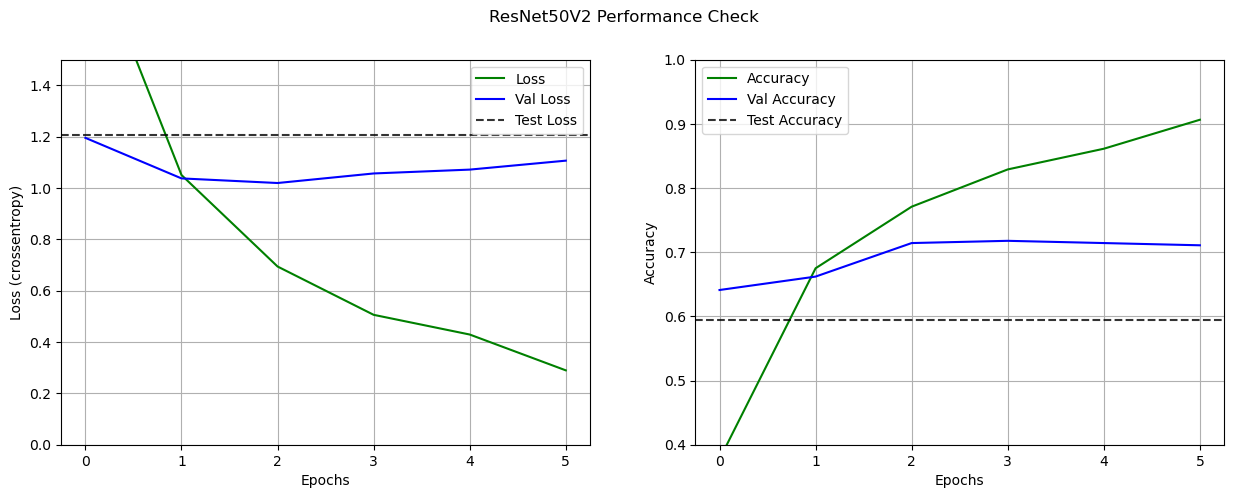

In [ ]:
# Initialize the ResNet50V2 model
resnet50_model = Model(model_name="ResNet50V2")

# Train the model
resnet50_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet50_model.evaluate(testXs, testYs, visualize=True, verbose=0)

The **current overfitting** observed in the model is **in line with our expectations,** as our **primary objective** is to **identify** the **most suitable backbone** for our **final model**. Thus, this **behavior should not be a cause for concern at this stage**.

While there is a **noticeable gap** of approximately **0.2** between the **training accuracy** and the **validation accuracy**, this variance can be **effectively addressed through the process of hyperparameter tuning**. It's worth noting that the **significant difference between validation loss and training loss** is a **key area of focus**. This discrepancy may imply various scenarios – **either the real-world data mimics the characteristics of the validation data, or our model requires further optimization**.

It's important to emphasize that this current model serves as a **preliminary testing framework solely for evaluating the suitability** of the chosen **backbone**. Given the nature of this **testing phase**, the **model's efficiency might not be fully indicative of its future performance**.

Interestingly, the **proximity** of **testing accuracy** to the **validation accuracy**, despite being distant from the **training accuracy**, suggests a **promising trajectory**. These early signs of improvement indicate that this **model can serve as a solid backbone** for our project. With the aid of **hyperparameter tuning** and subsequent **optimization**, we can **confidently leverage** this **backbone** to construct a **more robust and accurate final model**.

## **ResNet152V2**

---

The **ResNet152V2 architecture** represents a **progressive step** towards more advanced and intricate deep learning networks. As we venture into more complex models, it's essential to assess their potential as backbones for our farm insect classification task.

**ResNet152V2** shares the same fundamental principles as its predecessor, **ResNet50V2**, but extends its depth and complexity. The additional layers and features within this architecture offer a greater capacity to learn intricate patterns and nuances from our farm insect images.

By transitioning to **ResNet152V2**, we embark on a journey to explore the capabilities of a more robust and intricate model. As we delve deeper into the layers of this architecture, we can harness its advanced feature extraction capabilities and evaluate its compatibility with our classification task.

We will scrutinize the training process and closely monitor its performance, aiming to strike a balance between complexity and efficiency. Through this analysis, we can determine whether **ResNet152V2** possesses the characteristics we need for a strong backbone in our farm insect classification model.

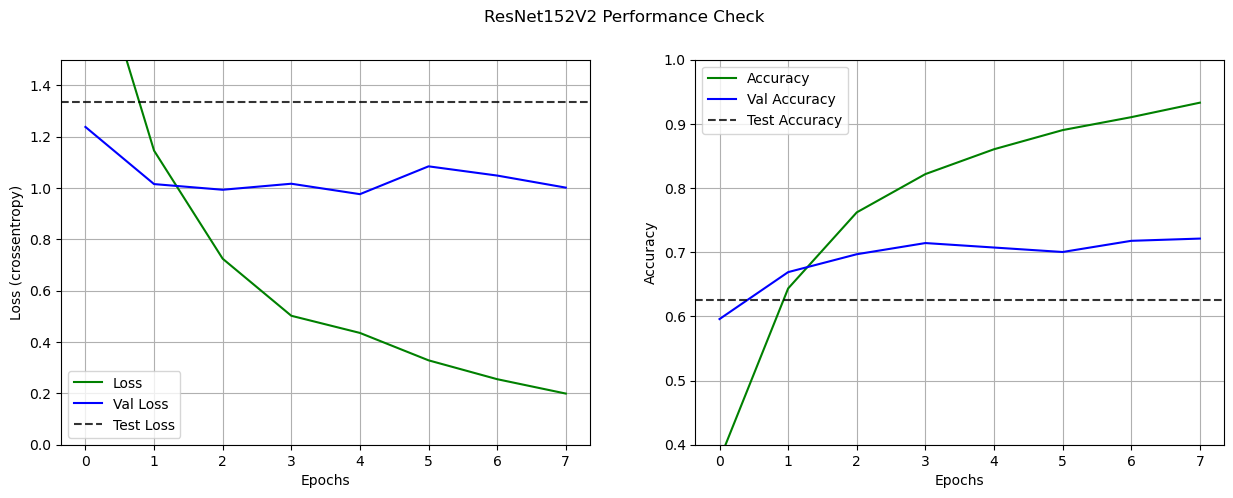

In [ ]:
# Initialize the ResNet152V2 model
resnet152_model = Model(model_name="ResNet152V2")

# Train the model
resnet152_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet152_model.evaluate(testXs, testYs, visualize=True, verbose=0)

The performance exhibited by the **ResNet152V2 model** reveals **intriguing similarities to its predecessor**. This **resemblance** could be attributed to the **shared foundational operations** employed by both models in their **feature extraction process**.

**ResNet152V2**, building upon the principles of its **ResNet lineage**, emphasizes the construction of **deeper architectures** to capture intricate features within the data. The model's extended depth offers **potential advantages** in terms of **feature representation**, enabling it to **discern finer nuances in the images**.

Observing the performance of the **ResNet152V2 model**, it becomes apparent that **notable performance enhancements** are **not readily discernible compared to its counterparts**. Given this observation, it may be **prudent to shift our focus back to the ResNet50V2 model**.

## **MobileNetV2**

---

The **MobileNetV2 architecture** introduces a different perspective to our quest for an optimal backbone in our farm insect classification endeavor. As we explore various models, it's imperative to consider the unique strengths and characteristics that MobileNetV2 brings to the table.

**MobileNetV2** is designed with a focus on efficiency, making it an excellent candidate for scenarios with limited computational resources. Its streamlined architecture and depthwise separable convolutions allow for significant reduction in parameters and computational complexity without compromising on performance.

Incorporating **MobileNetV2** into our analysis offers a fresh viewpoint, one that emphasizes efficiency and agility. By leveraging its lightweight structure, we aim to strike a harmonious balance between accuracy and resource efficiency in our classification task.

As we immerse ourselves in the intricacies of **MobileNetV2**, we'll unravel its potential as a backbone and its adaptability to our farm insect classification requirements. Our journey with this architecture will shed light on its suitability for our model's foundation, considering both performance and efficiency as key metrics.

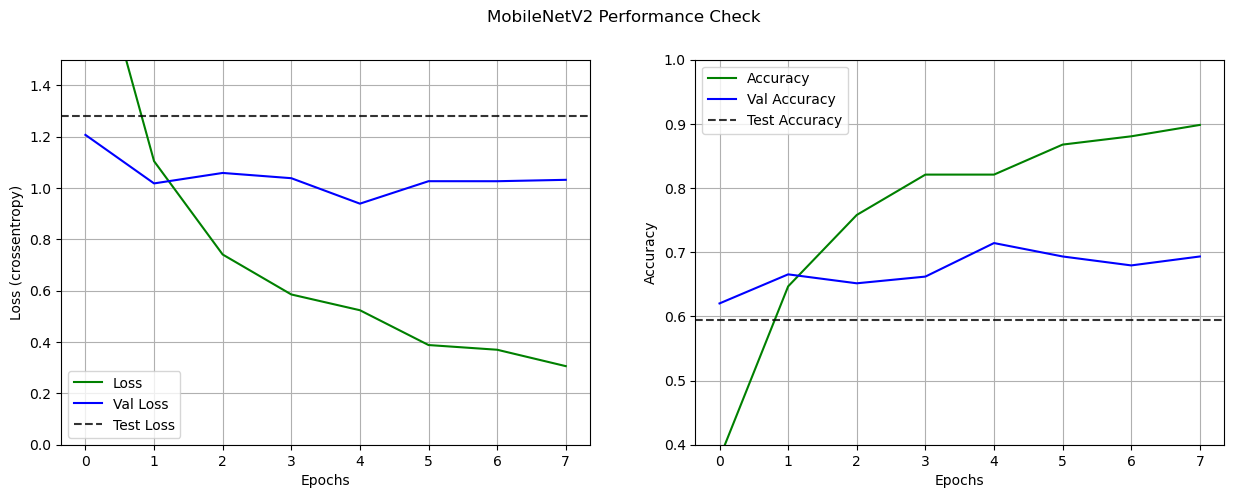

In [ ]:
# Initialize the MobileNetV2 model
mobilenetv2_model = Model(model_name="MobileNetV2")

# Train the model
mobilenetv2_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
mobilenetv2_model.evaluate(testXs, testYs, visualize=True, verbose=0)

Examining the performance data, it becomes apparent that the **MobileNetV2** model demonstrates consistent **performance levels** across both **training** and **validation phases**. However, its **testing performance** exhibits a **less favorable** or even **deteriorated trend**. Consequently, the prospect of adopting the **MobileNetV2** model may warrant reevaluation, given the observed limitations in its testing performance.

## **Xception**

---

The **Xception model** is a **deep neural network architecture** that has shown **impressive performance** across **various computer vision tasks**. It is recognized for its **innovative approach** to **convolutional neural networks (CNNs)** by decoupling the **spatial and channel-wise filtering operations**. This architecture enables the model to capture **intricate features** from images and has been **particularly effective in image classification tasks**.

**Xception's** design philosophy aims to enhance the **learning capability** of the network while **minimizing computational complexity.** Its **depthwise separable convolutions** and efficient use of **parameters contribute** to its **efficiency**, making it **suitable for tasks where computational resources are a consideration**.

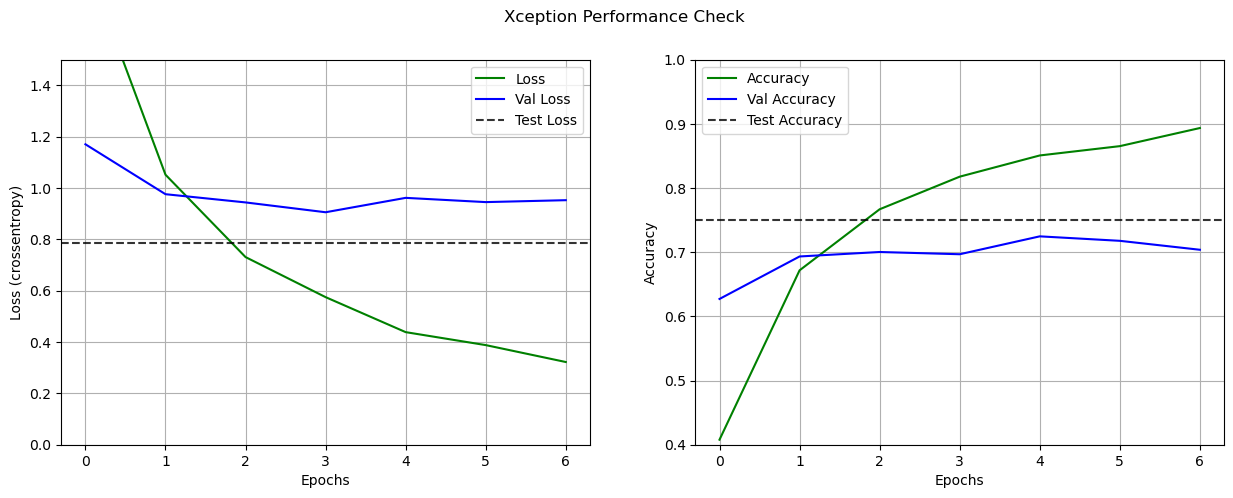

In [ ]:
# Initialize the Xception model
xception_model = Model(model_name="Xception")

# Train the model
xception_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
xception_model.evaluate(testXs, testYs, visualize=True, verbose=0)

Remarkably, we observe a **noticeable enhancement** in the **model's performance** with the **Xception architecture**. While the **training and validation results** exhibit a **consistency akin to our earlier models**, the noteworthy advancement lies in the **testing performance**. This **substantial improvement** signifies **the Xception model's potential to serve as an optimal backbone.**

The pronounced progress witnessed in the testing performance indicates that the **Xception model** is poised to become a **formidable cornerstone** for our **classification framework**. Its potential for **further refinement through hyperparameter tuning** instills confidence in its ability to be finely tailored to our dataset, **ensuring robustness and precision**.

# **Hypertuning**

---
We were able to successfully search for the best backbone that can be used for a fine and model. And this backbone is the exception model. This is because this model performed exceptionally well with the other models in comparison. Although one thing that I have noticed is that, because of the lack of images, the. is a slight difficulty to train the models, although we will try our best to perform hypertuning and make this model more robust. Improve its performance and make it applicable on the real world data. It already. shows promising results. Thus we are expecting it to show and improve the performance

In [ ]:
def build_model(hp):

    model_base = Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE)
    model_base.trainable = True

    model = Sequential([
        model_base,
        GlobalAveragePooling2D(),
        Dropout(hp.Choice("rate", [0.4, 0.5])),
    ])

    for _ in range(hp.Choice("n_layers", [1, 2, 3])):
        model.add(
            Dense(hp.Choice("Units", [128, 256, 1024]), activation="relu"),
        )
    model.add(Dense(N_CLASSES, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-4, 1e-6])),
        metrics=['accuracy']
    )

    return model

In [ ]:
kt = Hyperband(
    build_model,
    max_epochs=10,
    objective='val_accuracy',
    project_name="XceptionHS",
    overwrite=True,
    factor=5
)
kt.search(trainXs, trainYs, validation_data=(validXs, validYs))

Trial 13 Complete [00h 02m 37s]
val_accuracy: 0.11846689879894257

Best val_accuracy So Far: 0.7770034670829773
Total elapsed time: 00h 21m 28s


After conducting an **extensive hyperparameter search** employing the **hyperband strategy** and completing a series of **13 trials**, we achieved a remarkable validation accuracy of **0.777**, corresponding to **77.7%**. Observing the context established by **established benchmarks**, it becomes evident that **surpassing the accuracy threshold of 72% presents a significant challenge** for models. A thorough analysis of the **training curves** for each model underscores a consistent hurdle encountered by all, where exceeding this **72% benchmark proves intricate**.

Remarkably, our meticulously tuned model has managed to **overcome this barrier**, achieving a notable **5% improvement** over the threshold, amounting to an impressive accuracy of **77%**. This substantial advancement positions the model as a **noteworthy contender** among its predecessors. Considering the performance of the other models in the cohort, it becomes evident that this particular model stands as a **notable achievement**, having **outperformed its counterparts**.

**Keeping in mind that Xception stands out as the sole model to achieve a level of testing performance closely akin to its validation performance**, a noteworthy distinction becomes apparent. Unlike the other models, which exhibited a **pronounced variance between validation and testing performance**, this phenomenon has been notably **ameliorated through the process of hypertuning**.

The **Xception model's performance remains consistently aligned with the validation data**, indicative of its **compatibility with real-world scenarios**. While the **loss curve** does suggest **residual signs of overfitting**, a more comprehensive view of the **training curve reinforces the model's resilience and robustness** in tackling the challenges of our classification task.

In [ ]:
# Extract the Best Model
best_model = kt.get_best_models()[0]

# The best model architecture
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                        

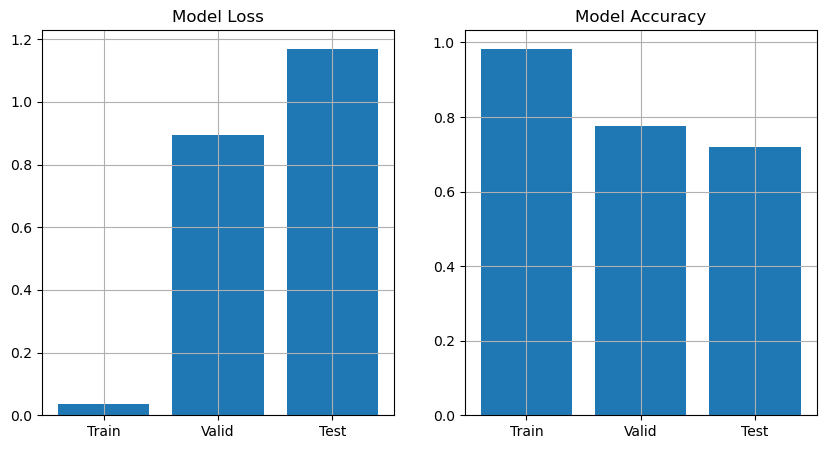

In [ ]:
# Model evaluation
train_loss, train_acc = best_model.evaluate(trainXs, trainYs, verbose=0)
valid_loss, valid_acc = best_model.evaluate(validXs, validYs, verbose=0)
test_loss, test_acc = best_model.evaluate(testXs, testYs, verbose=0)

# Visualizing Model Performance
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.bar(["Train", "Valid", "Test"], [train_loss, valid_loss, test_loss])
plt.grid()

plt.subplot(1,2,2)
plt.title("Model Accuracy")
plt.bar(["Train", "Valid", "Test"], [train_acc, valid_acc, test_acc])
plt.grid()

plt.show()

# **Model Prediction**

---
Having gained an understanding of our models' performance through statistical measures, it's now time to **delve into a visual examination**. By plotting the images from our dataset alongside their corresponding predictions and true labels, we can form a **comprehensive picture of the model's performance**. This visual analysis provides us with valuable insights into the model's capability to accurately identify objects, especially in challenging scenarios. Through this approach, we aim to further **evaluate and appreciate the model's prowess in recognizing objects within complex contexts**.

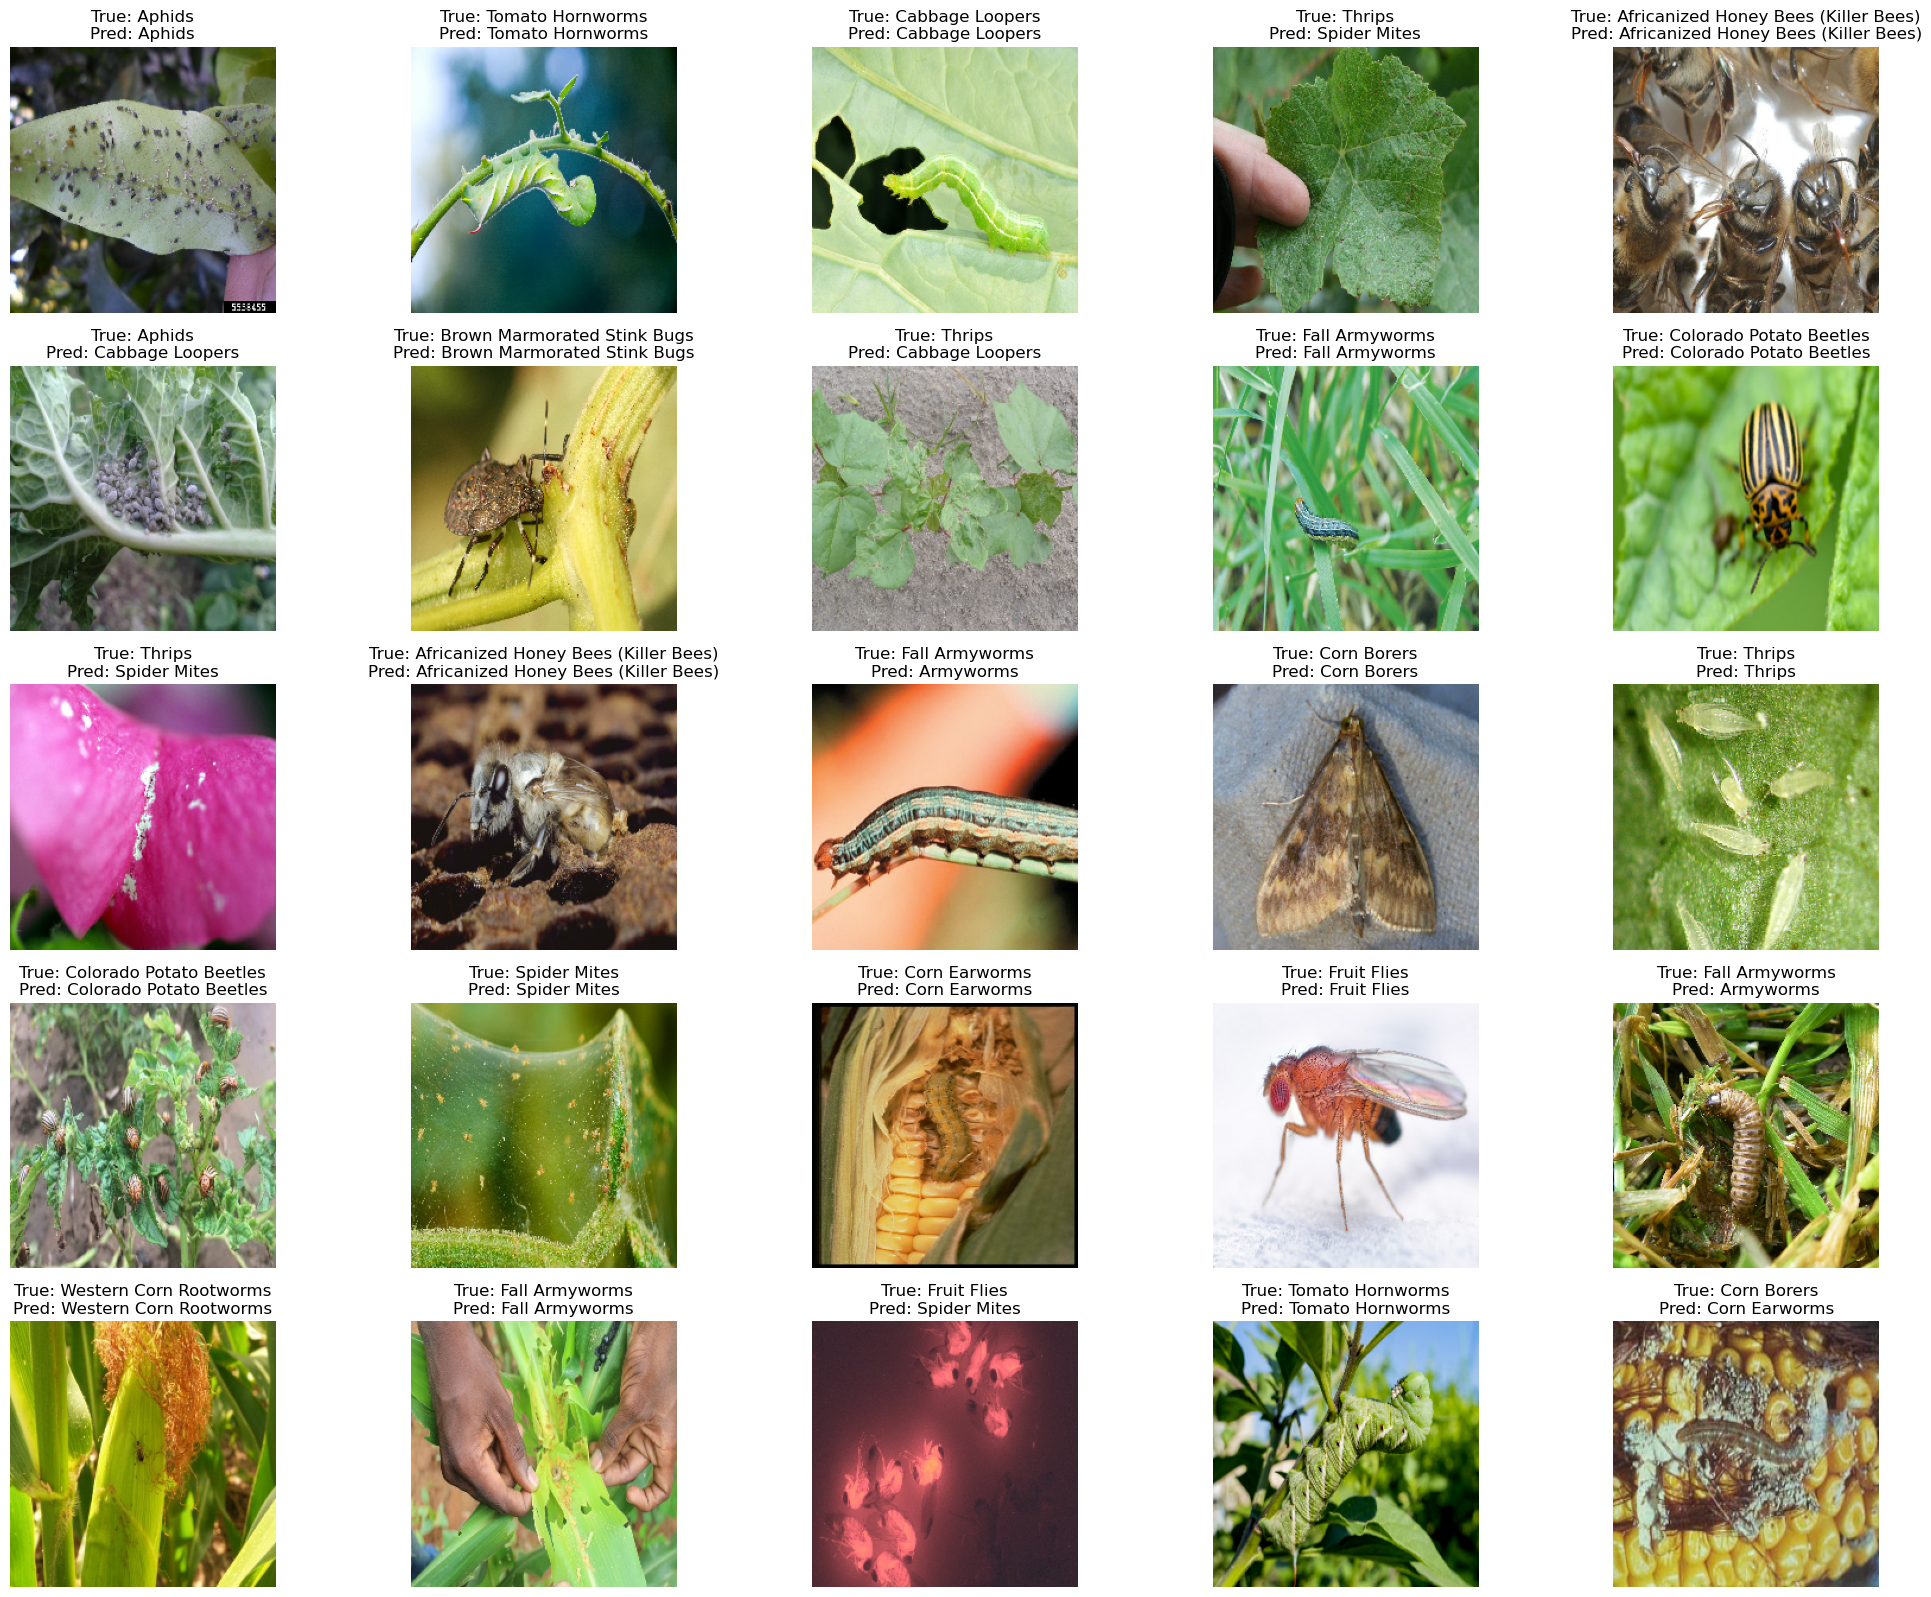

In [ ]:
# Define the number of rows and columns for the grid of images
n_rows, n_cols = [5, 5]
n_images = n_rows * n_cols

# Generate random image indexes from the test set
image_indexes = random.sample(range(len(testXs)), 25)

# Create a larger figure for displaying the grid of images
plt.figure(figsize=(25, 20))

# Iterate over the selected image indexes and plot each image with labels
for plot_index, index in enumerate(image_indexes):

    # Get the image and its corresponding true label
    image = testXs[index]
    true_label = class_names[np.argmax(testYs[index])]

    # Make a prediction using the trained model and get the predicted label
    prediction = best_model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    predicted_label = class_names[tf.argmax(prediction)]

    # Create a subplot within the grid
    plt.subplot(n_rows, n_cols, plot_index + 1)

    # Display the image
    plt.imshow(image)

    # Set the title to show the true and predicted labels
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

    # Turn off the axis ticks for cleaner presentation
    plt.axis('off')

# Display the grid of images
plt.show()


The model's predictions exhibit an impressive level of **accuracy**, with nearly all predictions aligning correctly. This underscores the model's high level of **robustness**, further highlighting its **effectiveness**. It's important to consider, however, that the testing dataset itself is relatively **small**. Despite the inherent limitations stemming from factors such as the constrained training data and the **class imbalance**, our model demonstrates a commendable performance level that exceeds initial **expectations**.

This iteration can be regarded as the **final model**. While additional rounds of **hypertuning** or the application of advanced techniques might yield even further **improvements**, it's worth noting that due to **time and resource constraints**, this model is already performing remarkably well. This accomplishment underscores the substantial impact of **transfer learning**, showcasing how it empowers us to develop a model for a new dataset without the need to build it from the **ground up**.

In [ ]:
# Saving the model weights
best_model.save("XceptionFarmInsectClassifier.h5")